In [1]:
import cv2
import torch
import os
import random
import math
import glob 
import pathlib
import csv, PIL
import time, zipfile
import pydicom

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from pydicom import dcmread
from tqdm import tqdm
from PIL import Image
from os import listdir
from torchvision import*

%matplotlib inline

## Path Setup

https://www.mathworks.com/matlabcentral/answers/482474-how-to-extract-the-main-square-image-window-of-the-ultrasound-image

https://www.raddq.com/dicom-processing-segmentation-visualization-in-python/

In [2]:
basepath = %pwd
print(os.listdir(basepath + '/Data/'))

['Dataset_BUSI_with_GT', 'masks', 'New_LungUS', 'patient list.xlsx', 'read_me.txt', 'data', '.ipynb_checkpoints', 'dcm_info.csv', 'LungUS_csv_dicom.csv', 'dcm_inf.csv']


In [3]:
inputdir = basepath + '/Data/data'
inputdir

'/home/Sean/Project/iRail_US/Data/data'

## Image Check Up

In [4]:
Captital_img  =  glob.glob(inputdir+os.sep+"/*/*.DCM")
lower_img  =  glob.glob(inputdir+os.sep+"/*/*.dcm")
image_dir = list(set(Captital_img) - set(lower_img))

print('Total number of Data: ', len(image_dir))

Total number of Data:  5062


In [5]:
Captital_img[:5], lower_img[:5]

(['/home/Sean/Project/iRail_US/Data/data/187/187_0027.DCM',
  '/home/Sean/Project/iRail_US/Data/data/187/187_0026.DCM',
  '/home/Sean/Project/iRail_US/Data/data/187/187_0025.DCM',
  '/home/Sean/Project/iRail_US/Data/data/187/187_0024.DCM',
  '/home/Sean/Project/iRail_US/Data/data/187/187_0023.DCM'],
 ['/home/Sean/Project/iRail_US/Data/data/080/N4260798934.dcm'])

> lower_img, 는 이름 저장 형식과, 나중에 Confusion을 야기 할 수 있으므로 drop 시킨다

Type of the random image: <class 'pydicom.dataset.FileDataset'> 
Shape of the random image: '(720, 960), 
Path : /home/Sean/Project/iRail_US/Data/data/014/014_0003.DCM


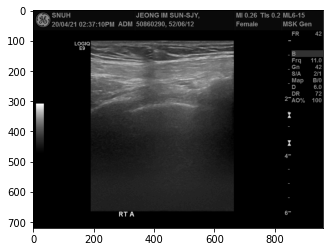

In [6]:
rand_path = random.choice(image_dir)
rand_img = pydicom.dcmread(rand_path)
plt.imshow(rand_img.pixel_array, cmap=plt.cm.gray)

print( f"Type of the random image: {type(rand_img)} \nShape of the random image: '{rand_img.pixel_array.shape}, \nPath : {rand_path}")

In [7]:
eg_img = pydicom.dcmread('/home/Sean/Project/iRail_US/Data/data/044_2/044_2_0004.DCM')
print(dir(eg_img))

['AccessionNumber', 'AcquisitionDateTime', 'BitsAllocated', 'BitsStored', 'BurnedInAnnotation', 'Columns', 'CommentsOnThePerformedProcedureStep', 'ContentDate', 'ContentTime', 'DerivationDescription', 'DeviceSerialNumber', 'HeartRate', 'HighBit', 'ImageType', 'InstanceCreationDate', 'InstanceCreationTime', 'InstanceNumber', 'InstitutionName', 'LossyImageCompression', 'Manufacturer', 'ManufacturerModelName', 'Modality', 'PatientBirthDate', 'PatientID', 'PatientName', 'PatientSex', 'PerformedProcedureStepDescription', 'PerformedProcedureStepID', 'PerformedProcedureStepStartDate', 'PerformedProcedureStepStartTime', 'PerformedProtocolCodeSequence', 'PhotometricInterpretation', 'PhysiciansOfRecord', 'PixelData', 'PixelRepresentation', 'PresentationIntentType', 'PresentationLUTShape', 'ProcedureCodeSequence', 'ProcessingFunction', 'ProtocolName', 'ReferencedPerformedProcedureStepSequence', 'ReferencedStudySequence', 'ReferringPhysicianName', 'RequestAttributesSequence', 'RequestingPhysician'

##  2. DCM Cropping


https://www.py4u.net/discuss/258625

https://vincentblog.xyz/posts/medical-images-in-python-computed-tomography


In [8]:
paths = image_dir
paths[:2]

['/home/Sean/Project/iRail_US/Data/data/005/005_0001.DCM',
 '/home/Sean/Project/iRail_US/Data/data/035/035_0012.DCM']

In [29]:
medical_image = pydicom.dcmread('/home/Sean/Project/iRail_US/Data/data/169/169_0009.DCM')
print(medical_image)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 210
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Ultrasound Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.113663.1500.1.423148221.3.10.20201214.134948.636
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.410.200010.12.0.3.6.1
(0002, 0013) Implementation Version Name         SH: 'INFINITT_361'
(0002, 0016) Source Application Entity Title     AE: 'US-004'
-------------------------------------------------
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'SMALL PARTS']
(0008, 0012) Instance Creation Date              DA: '20201214'
(0008, 0013) Instance Creation Time              TM: '134948'
(0008, 0016) SOP Class UID                       UI: Ultrasound Image Storage
(0008,

In [30]:
image = medical_image.pixel_array

print(image.shape)

(768, 1024)


In [31]:
print(image.min())
print(image.max())

0
255


> Now we have to transform the pixel values to the Hounsfield units, we can achieve this using the headers in the medical_image file, we will use the Rescale Intercept and Rescale Slope headers:

In [32]:
def transform_to_hu(medical_image, image):
    intercept = medical_image.RescaleIntercept
    slope = medical_image.RescaleSlope
    hu_image = image * slope + intercept

    return hu_image

In [33]:
def window_image(image, window_center, window_width):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max
    
    return window_image

In [39]:
def crop_image(image, display=False):
    # Create a mask with the background pixels
    mask = image == 0

    # Find the brain area
    coords = np.array(np.nonzero(~mask))
    top_left = np.min(coords, axis=1)
    bottom_right = np.max(coords, axis=1)
    
    # Remove the background
    croped_image = image[top_left[0]:bottom_right[0],
                top_left[1]:bottom_right[1]]
    
    return croped_image
    
def add_pad(image, new_height=512, new_width=512):
    height, width = image.shape

    final_image = np.zeros((new_height, new_width))

    pad_left = int((new_width - width) / 2)
    pad_top = int((new_height - height) / 2)
    
    # Replace the pixels with the image's pixels
    final_image[pad_top:pad_top + height, pad_left:pad_left + width] = image
    
    return final_image

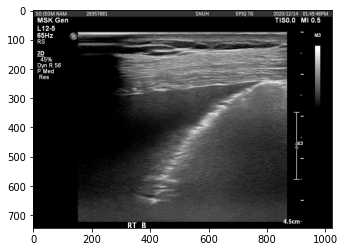

In [45]:
a = crop_image(image)

plt.imshow(a, cmap=plt.cm.gray)


In [46]:
import numpy as np
import pydicom
import cv2
import matplotlib.pyplot as plt
from skimage.transform import resize

In [ ]:
medical_image = pydicom.dcmread('/home/Sean/Project/iRail_US/Data/data/169/169_0009.DCM')
print(medical_image)

https://www.kaggle.com/davidbroberts/cropping-chest-x-rays

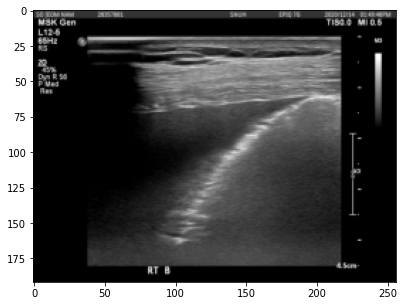

In [507]:
img = pydicom.dcmread('/home/Sean/Project/iRail_US/Data/data/169/169_0009.DCM')
# Resize the pixels
w = int(img.pixel_array.shape[0] * .25)
h = int(img.pixel_array.shape[1] * .25)

px = img.pixel_array / 255
img = resize(px, (w, h), anti_aliasing=True).astype(float)

# scale the pixels
img = (np.maximum(img,0) / img.max()) * 255.0
img = np.uint8(img)

# TODO: Invert MONOCHROME1 images here.

# Display the original image
plt.figure(figsize=(15,5))
plt.imshow(img,cmap="gray");

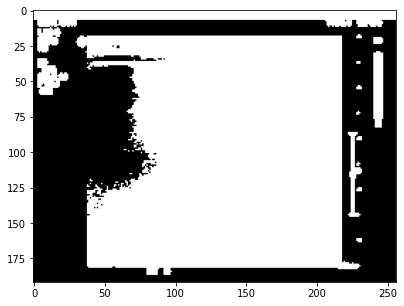

In [508]:
# Make a binarized copy of the image
thresh = 0
img_bin = cv2.threshold(img, thresh, 255, cv2.THRESH_BINARY)[1]

plt.figure(figsize=(15,5))
plt.imshow(img_bin,cmap="gray");

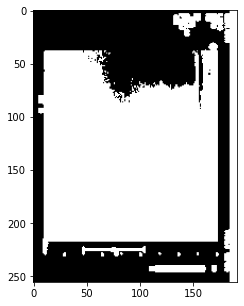

In [509]:
# Flip the image 90 degrees
img_bin = cv2.rotate(img_bin, cv2.cv2.ROTATE_90_CLOCKWISE)
plt.figure(figsize=(15,5))
plt.imshow(img_bin,cmap="gray");

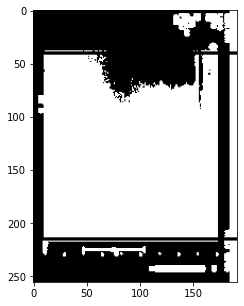

In [510]:
right = 0;
left = 0;
line_thickness = 2

# This is the value that specifies how bright a row is to consider it 'not the edge (too bright)'
intensity_threshold = 100

# Start at the bottom and work upwards checking the mean of pixels in every 10th row, this is the right side of the image
for i in range(img_bin.shape[0]-1,0,-10):
    row_mean = img_bin[i].mean()
    if row_mean > intensity_threshold:
        right = i
        
        # Draw a line where we want to crop
        cv2.line(img_bin, (0, i), (img_bin.shape[1], i), (0, img_bin.shape[1], 0), thickness=line_thickness)
        break
        
# Start at the top and go down to find the left side
for i in range(0,img_bin.shape[0]-1,10):
    row_mean = img_bin[i].mean()
    if row_mean > intensity_threshold:
        left = i
        
        # Draw a line where we want to crop
        cv2.line(img_bin, (0, i), (img_bin.shape[1], i), (0, img_bin.shape[1], 0), thickness=line_thickness)
        break
        
# Draw lines on the image where the mean intensity is > intensity_threshold
plt.figure(figsize=(15,5))
plt.imshow(img_bin,cmap="gray");

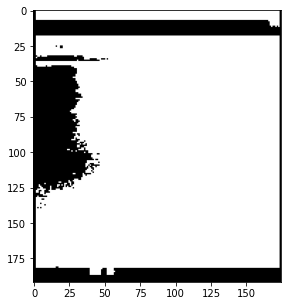

In [511]:
# Rotate the image back to it's normal orientation
img_bin = cv2.rotate(img_bin, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)

x1 = left
y1 = 0
x2 = right
y2 = img_bin.shape[1]

# Grab the region we identified from the binarized image
img_cropped = img_bin[y1:y2, x1:x2]
plt.figure(figsize=(15,5))
plt.imshow(img_cropped,cmap="gray");

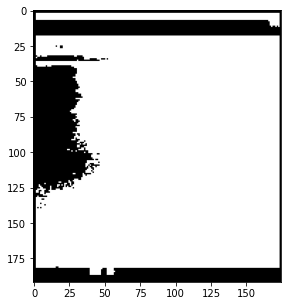

In [512]:
top = 0;
bottom = 0;

# Set some threshold values to specify what we consider edge vs patient
bright_threshold = 100
dark_threshold = 20

# Start at the bottom and work upward
for i in range(img_cropped.shape[0]-1,0,-10):
    row_mean = img_cropped[i].mean()
    if row_mean < bright_threshold:
        # Add 100 pixels of padding so we don't cut the costophrenic angles off
        bottom = i + 100
        cv2.line(img_cropped, (0, bottom), (img_cropped.shape[1], bottom), (0, img_cropped.shape[1], 0), thickness=line_thickness)
        break
        
# Start at the top and go down
for i in range(0,img_cropped.shape[0]-1,10):
    row_mean = img_cropped[i].mean()
    if row_mean > dark_threshold:
        top = i
        cv2.line(img_cropped, (0, i), (img_cropped.shape[1], i), (0, img_cropped.shape[1], 0), thickness=line_thickness)
        break
        
plt.figure(figsize=(15,5))
plt.imshow(img_cropped,cmap="gray");

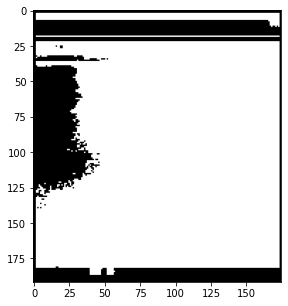

In [513]:
top = 0;
bottom = 0;

# Set some threshold values to specify what we consider edge vs patient
bright_threshold = 100
dark_threshold = 20

# Start at the bottom and work upward
for i in range(img_cropped.shape[0]-1,0,-10):
    row_mean = img_cropped[i].mean()
    if row_mean < bright_threshold:
        # Add 100 pixels of padding so we don't cut the costophrenic angles off
        bottom = i + 100
        cv2.line(img_cropped, (0, bottom), (img_cropped.shape[1], bottom), (0, img_cropped.shape[1], 0), thickness=line_thickness)
        break
        
# Start at the top and go down
for i in range(0,img_cropped.shape[0]-1,10):
    row_mean = img_cropped[i].mean()
    if row_mean > dark_threshold:
        top = i
        cv2.line(img_cropped, (0, i), (img_cropped.shape[1], i), (0, img_cropped.shape[1], 0), thickness=line_thickness)
        break
        
plt.figure(figsize=(15,5))
plt.imshow(img_cropped,cmap="gray");

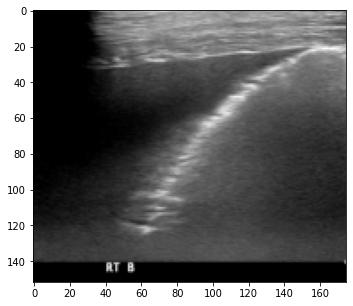

In [518]:
x1 = 0
y1 = top
x2 = img_bin.shape[0]
y2 = bottom

img_cropped = img_cropped[y1:y2, x1:x2]
plt.figure(figsize=(15,5))
plt.imshow(img_cropped,cmap="gray");

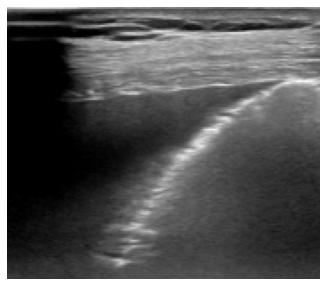

In [563]:
# Display the original image and the cropped section
img_cropped = img[top:bottom, left:right]
img_cropped = img_cropped[:-20]
plt.figure(figsize=(15,5))

plt.axis('off')
plt.imshow(img_cropped,cmap="gray")
os.makedirs(my_path + '/' +paths[2].split('/data/')[-1].split('/')[0], exist_ok=True)

plt.savefig(os.path.join(my_path, paths[2].split('/data/')[-1].split('.DCM')[0] + '.jpg'), bbox_inches="tight", pad_inches=0)        


In [546]:
paths[2].split('/data/')[-1].split('/')[0]

'058'

In [16]:
import os
dest = '/home/Sean/Project/iRail_US/cropped_data/Data'
my_path = os.path.abspath(dest) 

In [534]:
paths[2]

'/home/Sean/Project/iRail_US/Data/data/058/058_0021.DCM'

In [531]:
paths[2][38:]

'058/058_0021.DCM'

In [536]:
paths[2].split('/data/')[-1].split('.DCM')[0]

'058/058_0021'

In [530]:
len('/home/Sean/Project/iRail_US/Data/data/')

38

In [600]:
paths

['/home/Sean/Project/iRail_US/Data/data/169/169_0009.DCM',
 '/home/Sean/Project/iRail_US/Data/data/157/157_0026.DCM',
 '/home/Sean/Project/iRail_US/Data/data/058/058_0021.DCM',
 '/home/Sean/Project/iRail_US/Data/data/038/038_0004.DCM',
 '/home/Sean/Project/iRail_US/Data/data/122/122_0005.DCM',
 '/home/Sean/Project/iRail_US/Data/data/113/113_0016.DCM',
 '/home/Sean/Project/iRail_US/Data/data/135/135_0011.DCM',
 '/home/Sean/Project/iRail_US/Data/data/032/032_0008.DCM',
 '/home/Sean/Project/iRail_US/Data/data/047/047_0023.DCM',
 '/home/Sean/Project/iRail_US/Data/data/181/181_0008.DCM',
 '/home/Sean/Project/iRail_US/Data/data/039/039_0015.DCM',
 '/home/Sean/Project/iRail_US/Data/data/045/045_0003.DCM',
 '/home/Sean/Project/iRail_US/Data/data/136/136_0023.DCM',
 '/home/Sean/Project/iRail_US/Data/data/172/172_0005.DCM',
 '/home/Sean/Project/iRail_US/Data/data/094/094_0015.DCM',
 '/home/Sean/Project/iRail_US/Data/data/142/142_0023.DCM',
 '/home/Sean/Project/iRail_US/Data/data/081/081_0018.DCM

In [9]:
img = pydicom.dcmread(paths[202])

img = img.pixel_array

In [10]:
from skimage import exposure
import pydicom



In [11]:
ds= pydicom.dcmread(paths[2])


In [12]:
dcm_sample=ds.pixel_array


In [13]:
dcm_sample=exposure.equalize_adapthist(dcm_sample)


In [15]:
import cv2
import numpy as np

# load image as grayscale
#img = cv2.imread(dcm_sample)

gray = cv2.cvtColor(dcm_sample, cv2.COLOR_BGR2GRAY)

# threshold 
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
hh, ww = thresh.shape

# make bottom 2 rows black where they are white the full width of the image
thresh[hh-3:hh, 0:ww] = 0

# get bounds of white pixels
white = np.where(thresh==255)
xmin, ymin, xmax, ymax = np.min(white[1]), np.min(white[0]), np.max(white[1]), np.max(white[0])
print(xmin,xmax,ymin,ymax)

# crop the image at the bounds adding back the two blackened rows at the bottom
crop = img[ymin:ymax+3, xmin:xmax]

# save resulting masked image
cv2.imwrite('xray_chest_thresh.jpg', thresh)
cv2.imwrite('xray_chest_crop.jpg', crop)

# display result
cv2.imshow("thresh", thresh)
cv2.imshow("crop", crop)
cv2.waitKey(0)
cv2.destroyAllWindows()

error: OpenCV(4.5.3) /tmp/pip-req-build-tjxnaiom/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<1>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


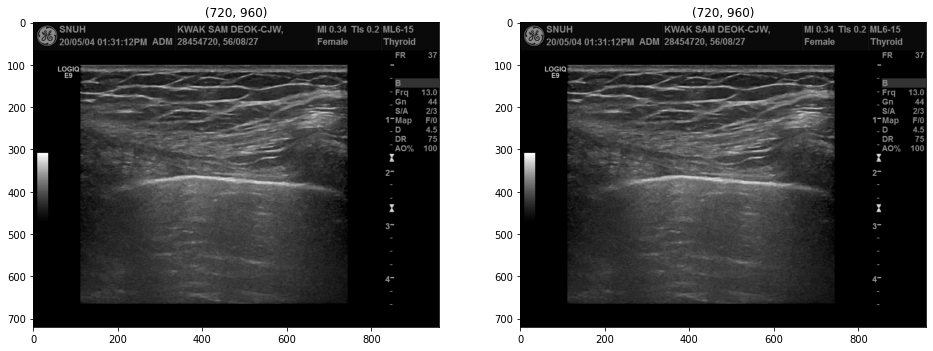

In [620]:
def crop_image(img: np.ndarray):
    edge_pixel_value = img[0, 0]
    mask = img != edge_pixel_value
    return img[np.ix_(mask.any(1),mask.any(0))]

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.imshow(img, cmap=plt.cm.gray)
plt.title(img.shape)

plt.subplot(122)
plt.imshow(crop_image(img), cmap=plt.cm.gray)
plt.title(crop_image(img).shape);

In [607]:
dest = '/home/Sean/Project/iRail_US/cropped_data/Data'
my_path = os.path.abspath(dest) 

for i in range(len(paths)):
    img = pydicom.dcmread(paths[i])
    
    w = int(img.pixel_array.shape[0] * .25)
    h = int(img.pixel_array.shape[1] * .25)
    px = img.pixel_array / 255
    img = resize(px, (w, h), anti_aliasing=True).astype(float)
    img = (np.maximum(img,0) / img.max()) * 255.0
    img = np.uint8(img)
    
    thresh = 0
    img_bin = cv2.threshold(img, thresh, 255, cv2.THRESH_BINARY)[1]
    img_bin = cv2.rotate(img_bin, cv2.cv2.ROTATE_90_CLOCKWISE)

    right = 0;
    left = 0;
    line_thickness = 2

    intensity_threshold = 100
    
    # Start at the bottom and work upwards checking the mean of pixels in every 10th row, this is the right side of the image
    for j in range(img_bin.shape[0]-1,0,-10):
        row_mean = img_bin[j].mean()
        if row_mean > intensity_threshold:
            right = j

            # Draw a line where we want to crop
            cv2.line(img_bin, (0, j), (img_bin.shape[1], j), (0, img_bin.shape[1], 0), thickness=line_thickness)
            break

    # Start at the top and go down to find the left side
    for k in range(0,img_bin.shape[0]-1,10):
        row_mean = img_bin[k].mean()
        if row_mean > intensity_threshold:
            left = k

            # Draw a line where we want to crop
            cv2.line(img_bin, (0, k), (img_bin.shape[1], k), (0, img_bin.shape[1], 0), thickness=line_thickness)
            break

    # Rotate the image back to it's normal orientation
    img_bin = cv2.rotate(img_bin, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)

    x1 = left
    y1 = 0
    x2 = right
    y2 = img_bin.shape[1]

    # Grab the region we identified from the binarized image
    img_cropped = img_bin[y1:y2, x1:x2]

    top = 0;
    bottom = 0;

    # Set some threshold values to specify what we consider edge vs patient
    bright_threshold = 120
    dark_threshold = 5

    # Start at the bottom and work upward
    for v in range(img_cropped.shape[0]-1,0,-10):
        row_mean = img_cropped[v].mean()
        if row_mean < bright_threshold:
            # Add 100 pixels of padding so we don't cut the costophrenic angles off
            bottom = v + 100
            cv2.line(img_cropped, (0, bottom), (img_cropped.shape[1], bottom), (0, img_cropped.shape[1], 0), thickness=line_thickness)
            break

    # Start at the top and go down
    for w in range(0,img_cropped.shape[0]-1,10):
        row_mean = img_cropped[w].mean()
        if row_mean > dark_threshold:
            top = w
            cv2.line(img_cropped, (0, w), (img_cropped.shape[1], w), (0, img_cropped.shape[1], 0), thickness=line_thickness)
            break

    x1 = 0
    y1 = top
    x2 = img_bin.shape[0]
    y2 = bottom

    img_cropped = img_cropped[y1:y2, x1:x2]

    x1 = 0
    y1 = top
    x2 = img_bin.shape[0]
    y2 = bottom

    img_cropped = img_cropped[y1:y2, x1:x2]
    
    img_cropped = img[top:bottom, left:right]
    img_cropped = img_cropped[:-20]
    #plt.figure(figsize=(15,5))

    plt.axis('off')
    #plt.imshow(img_cropped,cmap="gray")
    
    os.makedirs(my_path + '/' + paths[i].split('/data/')[-1].split('/')[0], exist_ok=True)

    plt.savefig(os.path.join(my_path, paths[i].split('/data/')[-1].split('.DCM')[0] + '.jpg'), bbox_inches="tight", pad_inches=0)        




TypeError: '>=' not supported between instances of 'dict' and 'int'

In [ ]:
for oprs in range(len(paths)): 
        #ik = (paths[oprs].split('/data/')[-1].split('/')[0])
        plt.axis('off')
        plt.imshow(img_cropped,cmap="gray")
        os.makedirs(my_path + '/' + paths[oprs].split('/data/')[-1].split('/')[0], exist_ok=True)
        plt.savefig(os.path.join(my_path, paths[oprs].split('/data/')[-1].split('.DCM')[0] + '.jpg'), bbox_inches="tight", pad_inches=0) 
        #print(oprs)
    #os.makedirs(my_path + '/' + paths[oprs].split('/data/')[-1].split('/')[0], exist_ok=True)

    #plt.savefig(os.path.join(my_path, paths[oprs].split('/data/')[-1].split('.DCM')[0] + '.jpg'), bbox_inches="tight", pad_inches=0)      

In [576]:
numbers = ['one', 'two', 'three', 'four', 'five']
    
for n in numbers:
    print(n)

one
two
three
four
five


In [593]:
for i in range(len(paths)): 
    ik = (paths[i].split('/data/')[-1].split('/')[0])
    
print(ik)

102_2


In [574]:
paths[1].split('/data/')[-1].split('/')[0]

'157'

In [571]:
my_path 

'/home/Sean/Project/iRail_US/cropped_data/Data'

## DCM2Image
1. Convert all images to gray scale 
2. Change to PNG
3. RoI BoX
4. Crop

In [37]:
import os

import pydicom
import numpy as np 

from PIL import Image

In [18]:
pathh = glob.glob(inputdir+os.sep+"/*/")
pathh

['/home/Sean/#Project/iRail_US/Data/LungUS/187/',
 '/home/Sean/#Project/iRail_US/Data/LungUS/186/',
 '/home/Sean/#Project/iRail_US/Data/LungUS/185/',
 '/home/Sean/#Project/iRail_US/Data/LungUS/184/',
 '/home/Sean/#Project/iRail_US/Data/LungUS/183/',
 '/home/Sean/#Project/iRail_US/Data/LungUS/182/',
 '/home/Sean/#Project/iRail_US/Data/LungUS/181/',
 '/home/Sean/#Project/iRail_US/Data/LungUS/180/',
 '/home/Sean/#Project/iRail_US/Data/LungUS/179/',
 '/home/Sean/#Project/iRail_US/Data/LungUS/178/',
 '/home/Sean/#Project/iRail_US/Data/LungUS/177/',
 '/home/Sean/#Project/iRail_US/Data/LungUS/176/',
 '/home/Sean/#Project/iRail_US/Data/LungUS/175/',
 '/home/Sean/#Project/iRail_US/Data/LungUS/174/',
 '/home/Sean/#Project/iRail_US/Data/LungUS/173/',
 '/home/Sean/#Project/iRail_US/Data/LungUS/172/',
 '/home/Sean/#Project/iRail_US/Data/LungUS/171/',
 '/home/Sean/#Project/iRail_US/Data/LungUS/170/',
 '/home/Sean/#Project/iRail_US/Data/LungUS/169/',
 '/home/Sean/#Project/iRail_US/Data/LungUS/168/',


In [38]:
def convert(directory):
    im = dicom.dcmread('/home/Sean/#Project/iRail_US/Data/data/'+directory)
    im = im.pixel_array.astype(float)
    rescaled_image = (np.maximum(im,0)/im.max()) * 255 # float pixel
    final_image = np.uint8(rescaled_image) # integers pixels
    final_image = Image.fromarray(final_image)
    return final_image


In [25]:
path = '/home/Sean/#Project/iRail_US/Data/LungUS'
ct_image = os.listdir(path)
#ct_images = os.listdir(path + f"(/{ct_image})")
arr_filename = [x for x in Captital_img if x.endswith(".DCM")] 

In [27]:
arr_filename[:20]

['/home/Sean/#Project/iRail_US/Data/LungUS/187/187_0027.DCM',
 '/home/Sean/#Project/iRail_US/Data/LungUS/187/187_0026.DCM',
 '/home/Sean/#Project/iRail_US/Data/LungUS/187/187_0025.DCM',
 '/home/Sean/#Project/iRail_US/Data/LungUS/187/187_0024.DCM',
 '/home/Sean/#Project/iRail_US/Data/LungUS/187/187_0023.DCM',
 '/home/Sean/#Project/iRail_US/Data/LungUS/187/187_0022.DCM',
 '/home/Sean/#Project/iRail_US/Data/LungUS/187/187_0021.DCM',
 '/home/Sean/#Project/iRail_US/Data/LungUS/187/187_0020.DCM',
 '/home/Sean/#Project/iRail_US/Data/LungUS/187/187_0019.DCM',
 '/home/Sean/#Project/iRail_US/Data/LungUS/187/187_0018.DCM',
 '/home/Sean/#Project/iRail_US/Data/LungUS/187/187_0017.DCM',
 '/home/Sean/#Project/iRail_US/Data/LungUS/187/187_0016.DCM',
 '/home/Sean/#Project/iRail_US/Data/LungUS/187/187_0015.DCM',
 '/home/Sean/#Project/iRail_US/Data/LungUS/187/187_0014.DCM',
 '/home/Sean/#Project/iRail_US/Data/LungUS/187/187_0013.DCM',
 '/home/Sean/#Project/iRail_US/Data/LungUS/187/187_0012.DCM',
 '/home/

In [22]:
print(type(Captital_img), Captital_img[0])

<class 'list'> /home/Sean/#Project/iRail_US/Data/LungUS/187/187_0027.DCM


In [32]:
arr_filename = []

for i in range(len(Captital_img)):
    arr_filename.append(Captital_img[i].split('LungUS/')[-1])
    arr_filename.sort()
    
print(arr_filename[0])

001/001_0000.DCM


In [33]:
arr_filename[:20]

['001/001_0000.DCM',
 '001/001_0001.DCM',
 '001/001_0002.DCM',
 '001/001_0003.DCM',
 '001/001_0004.DCM',
 '001/001_0005.DCM',
 '001/001_0006.DCM',
 '001/001_0007.DCM',
 '001/001_0008.DCM',
 '001/001_0009.DCM',
 '001/001_0010.DCM',
 '001/001_0011.DCM',
 '001/001_0012.DCM',
 '001/001_0013.DCM',
 '001/001_0014.DCM',
 '001/001_0015.DCM',
 '001/001_0016.DCM',
 '001/001_0017.DCM',
 '001/001_0018.DCM',
 '001/001_0019.DCM']

In [24]:
arr_filename2 = []

for i in range(len(Captital_img)):
    arr_filename2.append(Captital_img[i].split('/')[-1])
    arr_filename2.sort()
    
print(arr_filename2[0])

001_0000.DCM


In [129]:
arr_filename[0]

'001/001_0000.DCM'

In [183]:
aa = f"{name[4:]}"
aa

'0000.DCM'

In [184]:
name

'001_0000.DCM'

In [246]:
arr_filename3 = []

for i in range(len(Captital_img)):
    arr_filename3.append(Captital_img[i].split('/home/Sean/#Project/iRail_US/Data/LungUS/')[1])
    arr_filename3.sort()
    
print(arr_filename3[0])

001/001_0000.DCM


> FileNotFoundError: [Errno 2] No such file or directory: '/home/Sean/#Project/iRail_US/Final_Images/001/001_0000.DCM.png'

In [194]:
final_path ='/home/Sean/#Project/iRail_US/Final_Images/'

In [28]:
def convert(directory):
    #im = dicom.dcmread('/home/Sean/#Project/iRail_US/Data/LungUS/'+directory)
    im = dicom.dcmread('/home/Sean/#Project/iRail_US/Data/LungUS/'+directory)
    im = im.pixel_array.astype(float)
    rescaled_image = (np.maximum(im,0)/im.max()) * 255 # float pixel
    final_image = np.uint8(rescaled_image) # integers pixels
    final_image = Image.fromarray(final_image)
    return final_image

In [259]:
arr_filename[0].split('/')[-1]

'001_0000.DCM'

In [30]:
import pydicom as dicom

In [40]:
def convert(directory):
    im = dicom.dcmread('/home/Sean/#Project/iRail_US/Data/data/'+directory)
    im = im.pixel_array.astype(float)
    rescaled_image = (np.maximum(im,0)/im.max()) * 255 # float pixel
    final_image = np.uint8(rescaled_image) # integers pixels
    final_image = Image.fromarray(final_image)
    return final_image


In [39]:
for name in arr_filename:
    image = convert(name)
    image.save('/home/Sean/#Project/iRail_US/Final_Images/' + name[:].split('/')[-1] + '.png')
        
inputdir = '/home/Sean/#Project/iRail_US/Final_Images'
png  =  glob.glob(inputdir+os.sep+"/*.png")
print(len(png))

TypeError: Cannot handle this data type: (1, 1, 800, 3), |u1

In [35]:
! rm -rf Final_Images

In [36]:
! mkdir Final_Images

In [134]:
inputdir = '/home/Sean/#Project/iRail_US/Final_Images'
inputdir

'/home/Sean/#Project/iRail_US/Final_Images'

In [137]:
jpgs  =  glob.glob(inputdir+os.sep+"/*.jpg")

In [139]:
len(jpgs)

4809